**Srayan Gangopadhyay**
*4th June 2020*

# Implementing vector fields

Starting with [animation code](./animate.ipynb)

/home/srayan/miniconda3/envs/y1project/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in multiply
/home/srayan/miniconda3/envs/y1project/lib/python3.7/site-packages/numpy/core/numeric.py:1596: RuntimeWarning: invalid value encountered in multiply
  multiply(a1, b2, out=cp0)
/home/srayan/miniconda3/envs/y1project/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in add
/home/srayan/miniconda3/envs/y1project/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in add


ValueError: Axis limits cannot be NaN or Inf

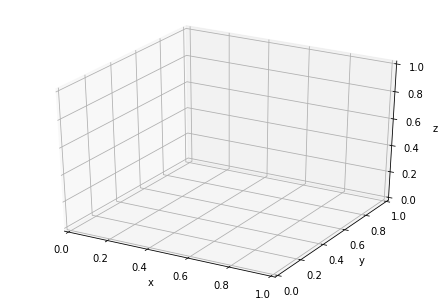

In [3]:
"""
Implementing vector fields
Srayan Gangopadhyay
2020-06-04
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from celluloid import Camera  # easy animation module
from IPython.display import HTML  # to display in notebook

# PARAMETERS
r0 = [0, 0, 0]  # initial position
v0 = [0/75e8, 0.75e8, 0]  # initial velocity
B = [15e-6, 25e-6, 0]  # magnetic field
E = [50, 75, 25]  # electric field
q, m = 1.6e-19, 1.67e-27  # charge, mass
h = 0.5  # step size
end = 100  # t-value to stop integration
size = [100,100,100]  # simulation dimensions

def lorentz(vel):  # returns acceleration
    return (q/m)*(E+np.cross(vel, B))

# RUNGE-KUTTA INTEGRATOR
def rk4(func, init1, init2, h, end):
    """
    Takes the RHS of a 2nd-order ODE with initial conditions,
     step size and end point, and integrates using the 4th-order
     Runge-Kutta algorithm. Returns solution in an array.

     r'' = f(t, r, v) where v = r'

     func: the function to be integrated
     init1: value of r at t=0
     init2: value of v at t=0
     h: step size
     end: t-value to stop integrating
    """

    steps = int(end/h)  # number of steps
    r = np.zeros((3, steps))  # empty matrix for solution
    v = np.zeros((3, steps))
    r[:,0] = init1  # inserting initial value
    v[:,0] = init2

    for i in range(0, steps-1):
        k1r = h * v[:,i]
        k1v = h * func(v[:,i])
        k2r = h * (v[:,i] + 0.5*k1v)
        k2v = h * func(v[:,i] + 0.5*k1v)
        k3r = h * (v[:,i] + 0.5*k2v)
        k3v = h * func(v[:,i] + 0.5*k2v)
        k4r = h * (v[:,i] + k3v)
        k4v = h * func(v[:,i] + k3v)
        new_r = r[:,i] + (k1r + 2*k2r + 2*k3r + k4r) / 6
        new_v = v[:,i] + (k1v + 2*k2v + 2*k3v + k4v) / 6
        
        if (new_r[0] < size[0]*-0.5):
            new_r[0] += size[0]  
        if (new_r[0] >= size[0]*0.5):
            new_r[0] -= size[0]
            
        if (new_r[1] < size[1]*-0.5):
            new_r[1] += size[1]
        if (new_r[1] >= size[1]*0.5):
            new_r[1] -= size[1]
            
        if (new_r[2] < size[2]*-0.5):
            new_r[2] += size[2]
        if (new_r[2] >= size[2]*0.5):
            new_r[2] -= size[2]
            
        r[:,i+1] = new_r
        v[:,i+1] = new_v
    return r

r = rk4(lorentz, r0, v0, h, end)

fig = plt.figure()
# camera = Camera(fig)  # set up the 'camera' on the figure
ax = Axes3D(fig)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

# for i in range(r.shape[1]):
    # plot data up to ith column and take snapshot
#     ax.plot3D(r[0, :i], r[1, :i], r[2, :i], '.', color='magenta')
#     camera.snap()
    
# animation = camera.animate(interval=20, blit=True)
# HTML(animation.to_html5_video())

ax.plot3D(r[0], r[1], r[2], '.')
plt.show()